# Linear Regression

## Introduction

This is an example of using Transformation and Measurement plugins.
The [API User Guide](../../api/user-guide/plugins/index.rst) has more information about the plugin system.
In this tutorial, we will be using the Theil-Sen estimator to create differentially private regressions. 

The Theil-Sen estimator is a robust method to fit a line to sample points by **choosing the median of the slopes between each pair of points in the data**. 

Compared to ordinary least squares regression, Theil-Sen regression has

- Lower sensitivity to outliers. 
- Higher accuracy for skewed and heteroskedastic data. 
- Fast algorithms for efficiently computing its parameters.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Theil–Sen_estimator), [University of Virgina StatLab](https://library.virginia.edu/data/articles/theil-sen-regression-programming-and-understanding-an-outlier-resistant-alternative-to-least-squares)

Let's get started! We will only need a few libraries for this tutorial. This tutorial has two parts: 

1. Define the Regression Functions 
2. Apply DP Regression on Synthetic Data

In [1]:
import opendp.prelude as dp
import numpy as np
import matplotlib.pyplot as plt

dp.enable_features("contrib")
dp.enable_features("honest-but-curious")

## Defining Regression Functions

We will define a series of functions and then compose them to create a pipeline to compute a differentially private regression.

### 1. Define Alphas

The following code defines alpha values that represent the 25th and 75th percentiles of the distribution of slopes computed from the random points in the dataset. 

We chose the 25th and 75th percentiles because they provide a nuanced understanding of the variability present in the dataset, but you can choose any that work best for your specific case.

In [2]:
alphas = np.array([[0.25], [0.75]])

### 2. Define a Function to Compute Points on the Percentile Lines

This function partitions a dataset into random pairs and then calculates a slope and midpoint for each pair in the dataset. 

It then outputs a set of points that represent the y-values at the specified percentiles (25th and 75th). Pairs where the difference between the points in the pair is not positive or is undefined are filtered out to ensure consistency. 

The percentiles will be applied to the y-values calculated from the lines defined by the slopes and midpoints at given percentiles.

In [3]:
def compute_points_on_percentiles(data):
    # Get an even number of rows.
    data = np.array(data, copy=True)[:len(data) // 2 * 2]

    # Shuffle the data for robustness.
    np.random.shuffle(data)

    # Split the data into pairs.
    p1, p2 = np.array_split(data, 2)

    # Compute differences.
    dx, dy = (p2 - p1).T

    # Compute slopes.
    slope = dy / dx

    # Compute the midpoints of the pairs. 
    x_bar, y_bar = (p1 + p2).T / 2

    # Compute points on line of percentiles. 
    points = slope * (alphas - x_bar) + y_bar

    # Keep only pairs where the x difference is positive. 
    return points.T[dx > 0]


### 3. Define a Function to Compute Differentially Private Percentiles

The `make_theil_sen_percentiles` function sets up a transformation that defines the format of the input data and applies the function `compute_points_on_percentiles` `runs` times to compute the required points on the lines on the specified percentiles. 

The parameter `runs` controls the number of independent Theil-Sen calculations performed and stacked together. The default is 1. Increasing `runs` can improve the robustness and accuracy of the results; however, it can also increase computational cost. 

In [4]:
def make_theil_sen_percentiles(runs: int=1):

    return dp.t.make_user_transformation(
        # Defines type of input. 
        input_domain=dp.numpy.array2_domain(T=float, num_columns=2),

        # The symmetric distance metric measures the number of changes required for transformation.
        input_metric=dp.symmetric_distance(),

        # Define output format. 
        output_domain=dp.numpy.array2_domain(T=float, num_columns=2),

        # Define output metric. 
        output_metric=dp.symmetric_distance(),

        # Apply the function runs times,
        function=lambda x: np.vstack([compute_points_on_percentiles(x) for _ in range(runs)]),
        stability_map=lambda b_in: runs * b_in)


### 4. Create a Function to Select a Specific Column

This function creates a transformation that selects a column from a dataset. 

In [5]:
def make_select_column(j):
    return dp.t.make_user_transformation(
        input_domain=dp.numpy.array2_domain(T=float, num_columns=2),
        input_metric=dp.symmetric_distance(),
        output_domain=dp.vector_domain(dp.atom_domain(T=float)),
        output_metric=dp.symmetric_distance(),
        function=lambda x: x[:, j],
        stability_map=lambda b_in: b_in)


### 5. Create a Function to Make Private Quantiles in Bounds

In this section, we will chain a transformation and measurement to compute the median with the existing quantile scores methods. First, we define the `discrete_scores` transformation by calling `dp.t.make_quantile_score_candidates` which outputs scores for how similar each candidate is to the given alpha-quantile on the input dataset.

In [ ]:
input_domain = dp.vector_domain(dp.atom_domain(T=float, nan=False))
input_metric = dp.symmetric_distance()
output_domain = np.array(list(range(100))).astype(float)
median_quantile = 0.5

discrete_scores = dp.t.make_quantile_score_candidates(
    input_domain, 
    input_metric, 
    output_domain, 
    median_quantile)
discrete_scores

Transformation(
    input_domain   = VectorDomain(AtomDomain(T=f64)),
    output_domain  = VectorDomain(AtomDomain(T=usize), size=100),
    input_metric   = SymmetricDistance(),
    output_metric  = LInfDistance(T=usize))

Next, we define the measurement to
1. Add Noise to Each Score. 
2. Find the Index of the Smallest Score. 

In [7]:
input_space = dp.vector_domain(dp.atom_domain(T=dp.usize), 100), dp.linf_distance(T=dp.usize)
select_index_measurement = dp.m.make_report_noisy_max_gumbel(*input_space, scale=1.0, optimize='min')
select_index_measurement

Measurement(
    input_domain   = VectorDomain(AtomDomain(T=usize), size=100),
    input_metric   = LInfDistance(T=usize),
    output_measure = MaxDivergence(f64))

Finally, we chain our transformation and measurement to create an intermediate pipeline to calculate the median of the slopes given a dataset with 2 columns. 

In [8]:
m_median = discrete_scores >> select_index_measurement
m_median

Measurement(
    input_domain   = VectorDomain(AtomDomain(T=f64)),
    input_metric   = SymmetricDistance(),
    output_measure = MaxDivergence(f64))

### 6. Create a Differentially Private Theil-Sen Estimator

In this final step, we chain the functions defined to compute the differentially private regression coefficients. 

The post-process function solves the regression coefficients by inverting the system. It performs a matrix-vector multiplication, scales and inverts it, and returns the resulting vector, which contains our regression coefficients. 

The first coefficient, alpha, is the slope of the line, and the second, beta, is the intercept. 


In [ ]:
def make_private_theil_sen(runs):
    def postprocess(p):
        return - np.array([[1, -1], [-.75, .25]]) @ p

    return make_theil_sen_percentiles(runs) >> dp.c.make_basic_composition([
        make_select_column(0) >> dp.t.then_impute_constant(0.0) >> m_median,
        make_select_column(1) >> dp.t.then_impute_constant(0.0) >> m_median,
    ]) >> postprocess

## Creating and Applying the Mechanism to Synthetic Data

Now apply the differentially private mechanism to a dataset. First, define an instance of the mechanism. 

In [10]:
meas = make_private_theil_sen(runs=1) 

Create synthetic data with a linear relationship. Remember to ensure the data aligns with our measurement's requirements. 

In [11]:
# Shift data by 5 for mostly positive data. 
x = np.random.normal(size=1_000) + 5
y = 2 * x + 3 + np.random.normal(size=1_000) + 5
data = np.stack([x, y], axis=1)
data = data.astype(np.float64)

Finally, pass the data to the regression function and get your differentially private coefficients.

The coefficients can be scaled by a parameter appropriate for your dataset. 

In [12]:
coef = meas(data) * 2
coef

array([2. , 8.5])

The first element of `coef` represents the slope; The second represents the y intercept. 

Plot these to see if our differentially private regression coefficients align well with the data. 

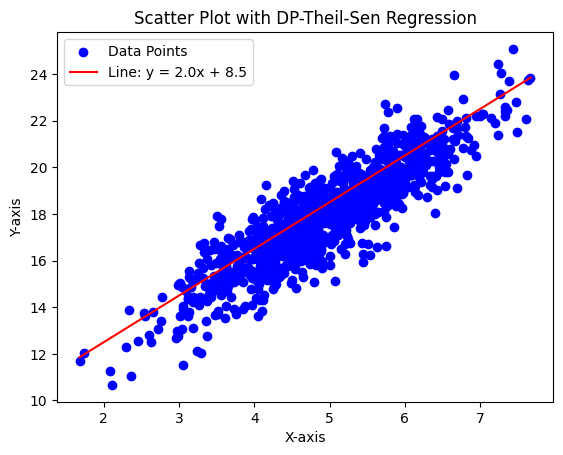

In [ ]:
x = data[:, 0]
y = data[:, 1]

m, b = coef
line_x = np.linspace(np.min(x), np.max(x), 100)
line_y = m * line_x + b

plt.scatter(x, y, color='blue', label='Data Points')
plt.plot(line_x, line_y, color='red', label=f'Line: y = {m}x + {b}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot with DP-Theil-Sen Regression')
plt.legend()

plt.show()


The DP regression results align well with the underlying synthetic data.

The DP regression pipeline is a powerful method to extract valuable information while preserving individual privacy. The methods used in this tutorial can serve as the foundation of your data science workflow and further regressions. 